# <b>CS156 (Introduction to AI), Spring 2022</b>
# <u><b>Homework 8 submission</b></u>

### Roster Name: Austin Rivard
### Student ID: 015044445
### Email address: austin.rivard@sjsu.edu

##  <u>References and sources </u>

List all your references and sources here.
This includes all sites/discussion boards/blogs/posts/etc. where you grabbed some code examples.

Excerpts taken from class reference notebooks CNN.Dog_vs_cat_images.ipynb and CNN.MNIST.ipynb by Dr. Yulia Newton

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pydot
from skimage import io
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

#### Code the solution

In [5]:
filepath = 'drive/MyDrive/Colab Notebooks/homework8_input_data/flowers'
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f'{filepath}/training',
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f'{filepath}/training',
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f'{filepath}/test',
    labels='inferred',
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=1

)

Found 3463 files belonging to 5 classes.
Using 2771 files for training.
Found 3463 files belonging to 5 classes.
Using 692 files for validation.
Found 861 files belonging to 5 classes.


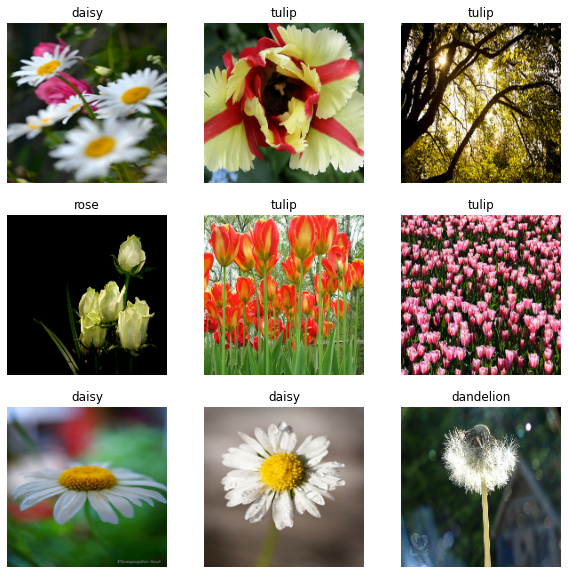

In [6]:
label_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        for j, k in enumerate(labels[i]):
          if k == 1:
            plt.title(label_names[j])
            break
        plt.axis("off")

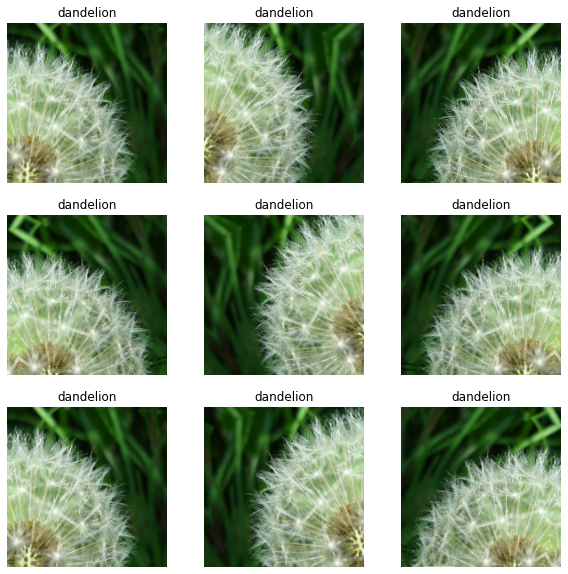

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[0].numpy().astype("uint8"))
        for j, k in enumerate(labels[0]):
          if k == 1:
            plt.title(label_names[j])
            break
        plt.axis("off")

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [9]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath + "/chkpts/save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 358s 4s/step - loss: 1.3122 - accuracy: 0.4940 - val_loss: 1.6825 - val_accuracy: 0.2587
Epoch 2/20
87/87 [==============================] - 45s 505ms/step - loss: 1.0366 - accuracy: 0.6077 - val_loss: 2.1218 - val_accuracy: 0.2587
Epoch 3/20
87/87 [==============================] - 44s 501ms/step - loss: 0.9415 - accuracy: 0.6485 - val_loss: 2.6658 - val_accuracy: 0.2587
Epoch 4/20
87/87 [==============================] - 45s 503ms/step - loss: 0.8360 - accuracy: 0.6835 - val_loss: 3.0845 - val_accuracy: 0.2587
Epoch 5/20
87/87 [==============================] - 44s 501ms/step - loss: 0.7585 - accuracy: 0.7210 - val_loss: 3.6558 - val_accuracy: 0.2587
Epoch 6/20
87/87 [==============================] - 45s 505ms/step - loss: 0.7354 - accuracy: 0.7178 - val_loss: 1.8594 - val_accuracy: 0.3974
Epoch 7/20
87/87 [==============================] - 44s 499ms/step - loss: 0.6757 - accuracy: 0.7467 - val_loss: 0.9937 - val_accuracy: 0.6618
E

In [57]:
predicted_labels = []
true_labels = []
misclassified_images = []
for image, label in test_ds:
    predicted = label_names[np.argmax(model.predict(image), axis=1)[0]]
    actual = label_names[np.argmax(label, axis=1)[0]]
    true_labels.append(actual)
    predicted_labels.append(predicted)
    if predicted != actual:
        misclassified_images.append((image, predicted, actual))
len(predicted_labels), len(true_labels)

(861, 861)

In [62]:
true_labels[:5], predicted_labels[:5]

(['sunflower', 'tulip', 'sunflower', 'daisy', 'sunflower'],
 ['sunflower', 'rose', 'dandelion', 'daisy', 'sunflower'])

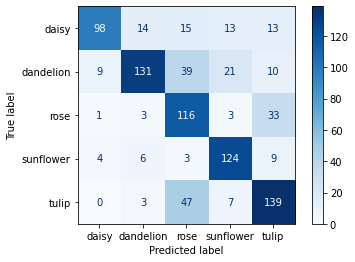

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, cmap='Blues')

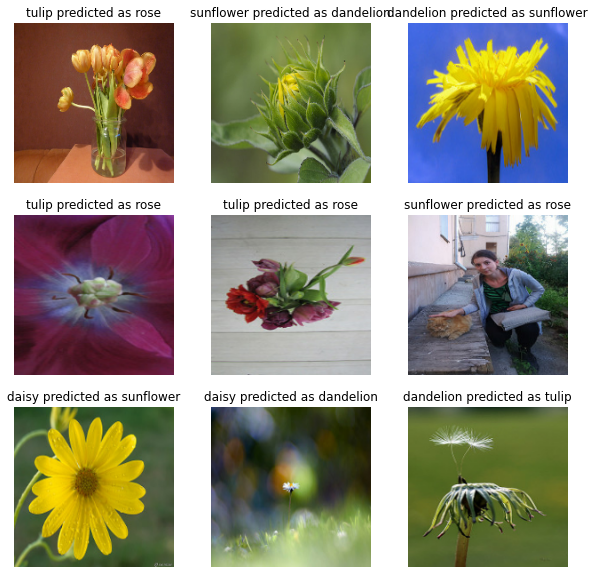

In [64]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image, pred, actual = misclassified_images[i]
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title(f'{actual} predicted as {pred}')
    plt.axis("off")